<a href="https://colab.research.google.com/github/Jingyi-Z/ThermalZZZ/blob/main/MNIST_thermalzzz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11/13/25 Original Version


In [1]:
! pip install optuna -q
! pip install xlsxwriter
! rm -rf ThermalZZZ
! git clone https://github.com/Jingyi-Z/ThermalZZZ.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 6.3 MB/s eta 0:00:00
Cloning into 'ThermalZZZ'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 719.45 KiB | 11.42 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
from importlib_resources import files, as_file
from openpyxl import load_workbook
import pickle
import time

from typing import Literal, Optional, Union
from sklearn.linear_model import LinearRegression
from numpy.linalg import matrix_rank
import secrets
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Subset,TensorDataset
from google.colab import drive
import csv
import os

from pylab import *
import xlsxwriter
from tkinter.filedialog import askopenfilename
import matplotlib.font_manager as fm
import optuna
import json, csv, time

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

USE_PIN_MEMORY = torch.cuda.is_available()
data_path = '/content/ThermalZZZ/Data_thermalzzz.xlsx'

plt.style.use("default")
mpl.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "savefig.transparent": True,
    "font.size": 9.5,
    "font.family": 'DejaVu Sans',
    "mathtext.fontset": "dejavusans",
    "axes.linewidth": 0.9,
    "axes.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 4,
    "xtick.minor.size": 2.5,
    "ytick.major.size": 4,
    "ytick.minor.size": 2.5,
    "legend.frameon": True,
    "legend.facecolor": "none",
    "legend.edgecolor": "0.85",
    "legend.framealpha": 0.95,
    "legend.fontsize": 8.5,
})


# Voltage pulse-temperature mapping

## 4 pulse -> 4 Temp

## 4 pulse -> 20 Temp

# Original ICGS

In [ ]:
# Log
# LOG_DIR = "/content/drive/MyDrive/oicgs_logs" # Log in Drive
LOG_DIR = "/content/logs" # Log in Colab
os.makedirs(LOG_DIR, exist_ok=True)
LOG_PATH = os.path.join(LOG_DIR, "ICGS_update_log.csv")  # single rolling log

def _to_scalar(x):
    """Best-effort: convert tensors/ndarrays/scalars to plain python scalars if size==1."""
    try:
        if isinstance(x, torch.Tensor):
            if x.numel() == 1:
                return x.detach().cpu().item()
            return f"<Tensor shape={tuple(x.shape)} dtype={x.dtype}>"
        if isinstance(x, np.ndarray):
            if x.size == 1:
                return x.item()
            return f"<ndarray shape={x.shape} dtype={x.dtype}>"
        if isinstance(x, (np.floating, np.integer)):
            return x.item()
        return x
    except Exception:
        return str(x)

def sanitize_params(p: dict):
    """Make params JSON-serializable without dumping huge arrays."""
    out = {}
    for k, v in p.items():
        if isinstance(v, (int, float, str, bool)) or v is None:
            out[k] = v
        elif isinstance(v, (np.ndarray, torch.Tensor)):
            # store a compact description instead of full data
            if isinstance(v, torch.Tensor):
                out[k] = f"<Tensor shape={tuple(v.shape)} dtype={v.dtype}>"
            else:
                out[k] = f"<ndarray shape={v.shape} dtype={v.dtype}>"
        else:
            # try scalar conversion, otherwise repr
            sv = _to_scalar(v)
            out[k] = sv if isinstance(sv, (int, float, str, bool)) or sv is None else repr(v)
    return out

def append_run_log(
    log_path: str,
    *,
    params: dict,
    seq_len: int,
    input_size: int,
    loss_train_per_epoch: list,
    acc_train_per_epoch: list,
    t_tot: float,
    t_per_epoch: float,
    acc_test: float,
    acc_test_95CI_low: float,
    acc_test_95CI_high: float,
    t_inf: float,
):
    """Append one row to CSV (create with header if missing)."""
    ts = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    row = {
        "timestamp": ts,
        "params_json": json.dumps(sanitize_params(params), ensure_ascii=False),
        "seq_len": seq_len,
        "input_size": input_size,
        "loss_train": json.dumps([_to_scalar(x) for x in loss_train_per_epoch]),
        "acc_train": json.dumps([_to_scalar(x) for x in acc_train_per_epoch]),
        "t_tot": float(t_tot),
        "t_per_epoch": float(t_per_epoch),
        "acc_test": float(acc_test),
        "acc_test_95CI_low":float(acc_test - 1.96*np.sqrt(acc_test*(1-acc_test))),
        "acc_test_95CI_high":float(acc_test + 1.96*np.sqrt(acc_test*(1-acc_test))),
        "t_inf": float(t_inf),
    }

    df = pd.DataFrame([row])
    # Create with header if not exists; else append without header
    if not os.path.exists(log_path):
        df.to_csv(log_path, index=False)
    else:
        df.to_csv(log_path, index=False, mode="a", header=False)

    print(f"Appended run to: {log_path}")

In [ ]:
# Load voltage-current mapping
import pickle
source_mapping = mapping_path
with open(source_mapping, 'rb') as fp:
    mapping = pickle.load(fp)

# Device Simulator
df = pd.read_excel(data_path).apply(pd.to_numeric, errors="coerce")

# EXP rows only (drop NaNs in EXP pair)
exp = df[["vbg_exp", "ids_exp"]].dropna(how="any")
b_vg_exp = exp["vbg_exp"].to_numpy()
b_id_exp = exp["ids_exp"].to_numpy()

# SIM rows only (drop NaNs in SIM pair)
sim = df[["vbg_sim", "ids_sim"]].dropna(how="any")
VBG_sim_new = sim["vbg_sim"].to_numpy()
ID_sim_new = sim["ids_sim"].to_numpy()

params = {
    "eps_ox1": 3.45e-11, #F/m
    "eps_ox2": 1.33e-10, #F/m
    "C_ox1": 3.45e-3, #F/m
    "C_ox2": 1.33e-2, #F/m
    "t_ox1": 1e-8, #m
    "t_ox2": 1e-8, #m
    "W": 1.5e-5, #m
    "L": 5e-7, #m
    "A": 7.5e-12, #m^2
    "V_p": 4, #V
    "V_ds": 1e-2, #V
     "V_shift": -1.5, #V
    "V_FB": -0.95, #V
    "n_e": 1.5, #a.u.
    "m": 0.9, #a.u.
    "a1": 0.72, #a.u., a2 = 1-a1
    "tau1": 4, #s
    "tau2": 506, #s
    "f": 2.5e-2, #Hz
    "N_digits": 8, #a.u.
    "VBG_sim_new": VBG_sim_new,
    "ID_sim_new": ID_sim_new,
    "VBG_exp": b_vg_exp,
    "ID_exp": b_id_exp,
    "gamma": 0.2,
    "rho": 1,
    "val_size":5000, # Validation set
    "train_size": 12000, # Smaller training set for fast training
    "num_epochs": 30,
    "batch_size": 64,
    "lr": 0.0001,
    "scaling": 1e7,
    "mapping": mapping, # For original ICGS
}

import time
num_epochs = params["num_epochs"]
batch_size = params["batch_size"]
lr = params["lr"]
seq_len = 8
input_size = int(576/seq_len)

class ICGSReservoirLayer(nn.Module):
    def __init__(self, input_size:int, seq_len:int, **params):
        super().__init__()
        self.params = params
        self.input_size = input_size
        self.seq_len = seq_len
        self.f = self.params.get("f")
        self.t_RC = np.linspace(0, self.seq_len/self.f,self.seq_len)

        mapping_tensor = torch.zeros((2**self.seq_len, self.seq_len))
        for i in range(2**self.seq_len):
            key = tuple(int(b) for b in format(i, f'0{self.seq_len}b'))
            key = key + (0,) * max(0, 8 - self.seq_len)
            value = mapping.get(tuple(key), [0.0] * self.seq_len)      # Fallback to zeros
            value = value[:self.seq_len]
            mapping_tensor[i] = torch.tensor(value)

        self.register_buffer("mapping_tensor", mapping_tensor)
        self.register_buffer("bit_weights", (2 ** torch.arange(self.seq_len - 1, -1, -1)))  # [128, 64, ..., 1]
        #self.register_buffer("bit_weights", (2 ** torch.arange(7, -1, -1)))  # [128, 64, ..., 1]

    def forward(self, x):
        # x shape: (batch_size, seq_len = self.seq_len, input_size = self.input_size)
        batch_size, self.seq_len, self.input_size = x.size()
        device = x.device

        # Initial reservoir state
        h_t = torch.zeros(batch_size, self.seq_len, self.input_size, device=device)

        # shape: [batch_size * input_size, seq_len]
        x = x.permute(0, 2, 1)  # [batch, input, seq_len]
        #x = x.reshape(-1, self.seq_len).long()  # [batch * input, seq_len]
        x = x.reshape(-1, self.seq_len)  # [batch * input, seq_len]
        indices = torch.matmul(x, self.bit_weights.int().to(x.device))  # [batch * input]
        responses = self.mapping_tensor[indices]
        h_t = responses.reshape(batch_size, input_size, seq_len).permute(0, 2, 1)
        return h_t*self.params.get("scaling")  # Final reservoir state used for classification

class ICGSReservoirNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, **params):
        super().__init__()
        self.reservoir = ICGSReservoirLayer(input_size, seq_len, **params)
        # Normalization
        self.bn = nn.BatchNorm1d(seq_len*input_size)
        # test on nonlinear projection
        self.readout = nn.Linear(seq_len*input_size, output_size)

    def forward(self, x):
        reservoir_state = self.reservoir(x)
        reservoir_state_reshaped = torch.reshape(reservoir_state, (reservoir_state.size(dim=0), reservoir_state.size(dim=1)* reservoir_state.size(dim=2)))
        reservoir_state_norm = self.bn(reservoir_state_reshaped)
        out = self.readout(reservoir_state_norm)
        #out = self.readout(reservoir_state_reshaped)
        return out

MNIST (Binarized)

In [ ]:
# Prepare MNIST Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def preprocess_image(tensor_img, threshold = 20):
    # tensor_img shape: [1, 28, 28], values in [0.0, 1.0]
    tensor_img = tensor_img.squeeze(0)*255
    binary_img = (tensor_img > threshold).int() # binarization
    cropped = binary_img[2:-2,2:-2] # crop the image to size [24,24]
    reshaped = cropped.reshape(seq_len,int(576/seq_len)) # seq_len = 8, input_size = 24*24/8 = 72
    return reshaped

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: preprocess_image(x))  # shape: [8, 72]
])

train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Validation dataset
from torch.utils.data import random_split
train_size = len(train_dataset) - params["val_size"]
train_subset, val_subset = random_split(
    train_dataset, [train_size,  params["val_size"]],
    generator=torch.Generator().manual_seed(42)
)

idx_small = torch.randperm(len(train_subset), generator=torch.Generator().manual_seed(42))[:params["train_size"]]
train_subset_small = Subset(train_subset, idx_small)
train_loader_local = DataLoader(train_subset_small, batch_size=64, shuffle=True, num_workers=2)
val_loader         = DataLoader(val_subset,   batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 9.91M/9.91M [00:00<00:00, 58.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.78MB/s]


In [ ]:
# Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ICG_model = ICGSReservoirNet(input_size = input_size, seq_len = seq_len, output_size=10, **params).to(device)
optimizer = torch.optim.Adam(ICG_model.readout.parameters(), lr=lr)  # Only train readout

loss_train_hist = []
acc_train_hist = []

criterion = nn.CrossEntropyLoss()
start_time = time.time()

for epoch in range(num_epochs):
    ICG_model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = ICG_model(x)
        output = F.log_softmax(output,dim =1)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    acc = correct / total
    loss_train_hist.append(total_loss)
    acc_train_hist.append(acc)
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {acc*100:.2f}%")

end_time = time.time()
t_total = end_time - start_time
t_per_epoch = t_total / num_epochs

print(f"Total training time: {t_total:.2f} seconds")
print(f"Training time per epoch: {t_per_epoch:.2f} seconds")

Epoch 1 | Loss: 845.8691 | Accuracy: 75.73%
Epoch 2 | Loss: 420.0674 | Accuracy: 88.12%
Epoch 3 | Loss: 351.6660 | Accuracy: 89.55%
Epoch 4 | Loss: 319.3690 | Accuracy: 90.45%
Epoch 5 | Loss: 301.3777 | Accuracy: 90.96%
Epoch 6 | Loss: 288.2765 | Accuracy: 91.23%
Epoch 7 | Loss: 281.1116 | Accuracy: 91.37%
Epoch 8 | Loss: 274.8292 | Accuracy: 91.62%
Epoch 9 | Loss: 269.2461 | Accuracy: 91.89%
Epoch 10 | Loss: 266.2864 | Accuracy: 91.86%
Epoch 11 | Loss: 260.3113 | Accuracy: 92.06%
Epoch 12 | Loss: 259.1507 | Accuracy: 92.13%
Epoch 13 | Loss: 256.0999 | Accuracy: 92.20%
Epoch 14 | Loss: 252.2376 | Accuracy: 92.36%
Epoch 15 | Loss: 252.8889 | Accuracy: 92.35%
Epoch 16 | Loss: 250.1048 | Accuracy: 92.34%
Epoch 17 | Loss: 248.9287 | Accuracy: 92.44%
Epoch 18 | Loss: 247.3616 | Accuracy: 92.37%
Epoch 19 | Loss: 244.8729 | Accuracy: 92.52%
Epoch 20 | Loss: 243.1103 | Accuracy: 92.56%
Epoch 21 | Loss: 242.2095 | Accuracy: 92.55%
Epoch 22 | Loss: 242.5478 | Accuracy: 92.62%
Epoch 23 | Loss: 24

Test Accuracy: 92.85% | Inference time: 8.02 seconds
Test Accuracy (95% CI): 92.34% - 93.36%


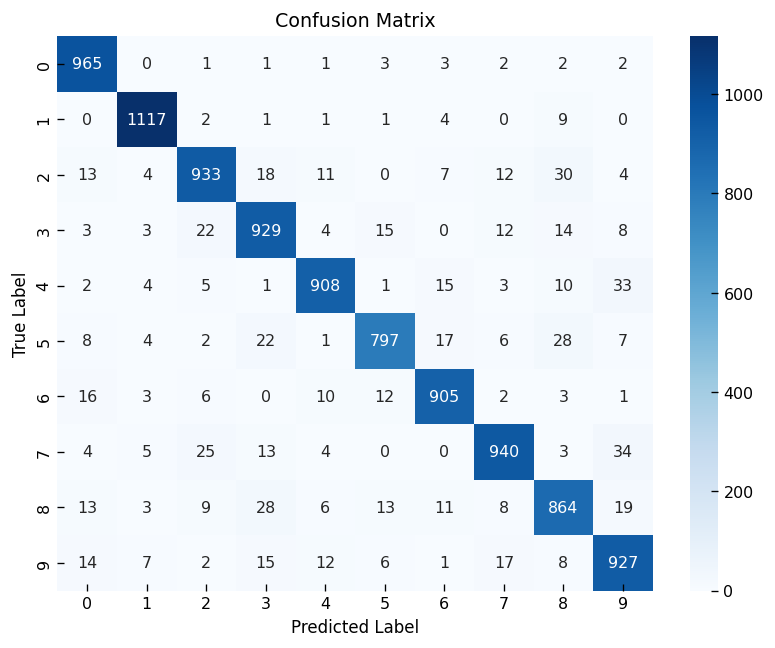

Appended run to: /content/drive/MyDrive/oicgs_logs/ICGS_update_log.csv


In [ ]:
# Evaluation
all_preds = []
all_labels = []

ICG_model.eval()  # set model to evaluation mode
tic = time.time()

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = ICG_model(x)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Inference time
t_inf = time.time()-tic

# Accuracy
acc_test = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc_test * 100:.2f}% | Inference time: {t_inf:.2f} seconds")

# Accuracy (95% Confidence Interval)
SE_test = np.sqrt(acc_test * (1 - acc_test) / len(all_labels))
z_score = 1.96  # 95% confidence interval
CI_test = (acc_test - z_score * SE_test, acc_test + z_score * SE_test)
print(f"Test Accuracy (95% CI): {CI_test[0]*100:.2f}% - {CI_test[1]*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

append_run_log(
    LOG_PATH,
    params=params,
    seq_len=seq_len,
    input_size=input_size,
    loss_train_per_epoch=loss_train_hist,
    acc_train_per_epoch=acc_train_hist,
    t_tot=t_total,
    t_per_epoch=t_per_epoch,
    acc_test=acc_test,
    acc_test_95CI_low=CI_test[0],
    acc_test_95CI_high=CI_test[1],
    t_inf=t_inf,
)

Hyperparameter Optimization

In [ ]:
def oICGS(signal,**params):

    def interfacial_charge(Vp, **params):
        try:
          m      = params["m"]
          t_ox1  = params["t_ox1"]
          t_ox2  = params["t_ox2"]
          eps_ox1= params["eps_ox1"]
          eps_ox2= params["eps_ox2"]
          A      = params["A"]
        except KeyError as e:
          raise KeyError(f"Missing required parameter: {e.args[0]}")

        E_ox1 = Vp / (t_ox1 + m * t_ox2)
        E_ox2 = m * Vp / (t_ox1 + m * t_ox2)
        sigma = - eps_ox1 * E_ox1 + eps_ox2 * E_ox2
        return [E_ox1, E_ox2, sigma]

    def decay_func(t,**params):
      try:
        a1 = params["a1"]
        a2 = 1-a1
        tau1 = params["tau1"]
        tau2 = params["tau2"]
      except KeyError as e:
        raise KeyError(f"Missing required parameter: {e.args[0]}")

      return a1*np.exp(-t/tau1)+a2*np.exp(-t/tau2)

    def threshold_shift(sigma, Vshift, **params):
      try:
        t_ox = params["t_ox1"]
        eps_ox = params["eps_ox1"]
      except KeyError as e:
        raise KeyError(f"Missing required parameter: {e.args[0]}")

      return -sigma * t_ox/eps_ox + Vshift

    def find_index(x,array):
        diff_array = np.absolute(np.asarray(array)-x)
        index = diff_array.argmin()
        return index


    f = params["f"]
    time = np.linspace(0,len(signal)/f,len(signal))
    VBG = params["VBG_sim_new"]
    ID = params["ID_sim_new"]
    gamma = params["gamma"]

    #Initialization
    if len(time)>1:
        t_interval = time[1]-time[0]
    else:
        t_interval = 0
    sigma_initial = interfacial_charge(Vp = 0, **params)[2]
    sigma_accumulated = [sigma_initial]
    sigma_accumulated_afterdecay = [0]
    sigma_generated = []
    delta_vth_sigma = []
    delta_vth_total = []
    sigma_saturate = []
    sigma_generated_temp = []
    current_index = []
    current = []

    #Set threshold
    signal_max, signal_min = max(signal), min(signal)
    sigma_saturate_max, sigma_saturate_min = interfacial_charge(Vp = signal_max, **params)[2], interfacial_charge(Vp = signal_min, **params)[2]

    if sigma_saturate_max>0 and sigma_saturate_min>0:
        sigma_saturate_pos = max(sigma_saturate_max, sigma_saturate_min)
        sigma_saturate_neg = 0
    elif sigma_saturate_max >0 and sigma_saturate_min <=0:
        sigma_saturate_pos = sigma_saturate_max
        sigma_saturate_neg = sigma_saturate_min
    elif sigma_saturate_max <=0 and sigma_saturate_min >0:
        sigma_saturate_pos = sigma_saturate_min
        sigma_saturate_neg = sigma_saturate_max
    else:
        sigma_saturate_pos = 0
        sigma_saturate_neg = min(sigma_saturate_max, sigma_saturate_min)

    # Calculate charge
    for i in range(len(time)):
        delta_vth_total.append(float(signal[i]))
        sigma_saturate.append(interfacial_charge(Vp = signal[i], **params)[2])
        sigma_generated_temp.append(sigma_saturate[i]*gamma*t_interval)

        if sigma_accumulated_afterdecay[i]+sigma_generated_temp[i] > sigma_saturate_pos:
            sigma_generated.append(sigma_saturate_pos-sigma_accumulated_afterdecay[i])
            sigma_accumulated.append(sigma_saturate_pos)

        elif sigma_accumulated_afterdecay[i]+sigma_generated_temp[i] < sigma_saturate_neg:
            sigma_generated.append(sigma_saturate_neg-sigma_accumulated_afterdecay[i])
            sigma_accumulated.append(sigma_saturate_neg)

        else:
            sigma_generated.append(sigma_generated_temp[i])
            sigma_accumulated.append(sigma_accumulated_afterdecay[i]+sigma_generated[i])

        sigma_accumulated_afterdecay_temp = 0
        for j in range(len(sigma_generated)):
            sigma_accumulated_afterdecay_temp += sigma_generated[j]*decay_func(time[i]-time[j], **params)
        sigma_accumulated_afterdecay.append(sigma_accumulated_afterdecay_temp)

        # Calculate threshold voltage shift and current
        delta_vth_sigma.append(threshold_shift(sigma_accumulated[i],Vshift = params["V_shift"],**params))
        delta_vth_total[i] += threshold_shift(sigma_accumulated[i],Vshift = params["V_shift"],**params)
        current_index.append(find_index(delta_vth_total[i],VBG))
        current.append(ID[find_index(delta_vth_total[i],VBG)])

    return [sigma_generated,sigma_accumulated,delta_vth_sigma,delta_vth_total,current]

class ICGSReservoirLayer(nn.Module):
    def __init__(self, input_size:int, seq_len:int, **params):
        super().__init__()
        self.params = params
        self.input_size = input_size
        self.seq_len = seq_len
        self.f = self.params.get("f")
        self.t_RC = np.linspace(0, self.seq_len/self.f,self.seq_len)

        mapping_tensor = torch.zeros((2**self.seq_len, self.seq_len))
        for i in range(2**self.seq_len):
            key = tuple(int(b) for b in format(i, f'0{self.seq_len}b'))
            key = key + (0,) * max(0, 8 - self.seq_len)
            value = mapping.get(tuple(key), [0.0] * self.seq_len)      # Fallback to zeros
            value = value[:self.seq_len]
            mapping_tensor[i] = torch.tensor(value)

        self.register_buffer("mapping_tensor", mapping_tensor)
        self.register_buffer("bit_weights", (2 ** torch.arange(self.seq_len - 1, -1, -1)))  # [128, 64, ..., 1]
        #self.register_buffer("bit_weights", (2 ** torch.arange(7, -1, -1)))  # [128, 64, ..., 1]

    def forward(self, x):
        # x shape: (batch_size, seq_len = self.seq_len, input_size = self.input_size)
        batch_size, self.seq_len, self.input_size = x.size()
        device = x.device

        # Initial reservoir state
        h_t = torch.zeros(batch_size, self.seq_len, self.input_size, device=device)

        # shape: [batch_size * input_size, seq_len]
        x = x.permute(0, 2, 1)  # [batch, input, seq_len]
        x = x.reshape(-1, self.seq_len).long()  # [batch * input, seq_len]
        #x = x.reshape(-1, self.seq_len)  # [batch * input, seq_len]
        indices = torch.matmul(x, self.bit_weights.to(x.device))  # [batch * input]
        responses = self.mapping_tensor[indices]
        h_t = responses.reshape(batch_size, input_size, seq_len).permute(0, 2, 1)
        return h_t*self.params.get("scaling")  # Final reservoir state used for classification

class ICGSReservoirNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, **params):
        super().__init__()
        self.reservoir = ICGSReservoirLayer(input_size, seq_len, **params)
        # Normalization
        self.bn = nn.BatchNorm1d(seq_len*input_size)
        # test on nonlinear projection
        self.readout = nn.Linear(seq_len*input_size, output_size)

    def forward(self, x):
        reservoir_state = self.reservoir(x)
        reservoir_state_reshaped = torch.reshape(reservoir_state, (reservoir_state.size(dim=0), reservoir_state.size(dim=1)* reservoir_state.size(dim=2)))
        reservoir_state_norm = self.bn(reservoir_state_reshaped)
        out = self.readout(reservoir_state_norm)
        #out = self.readout(reservoir_state_reshaped)
        return out

In [ ]:
# Prepare MNIST Dataset
train_size = 12000
val_size = 5000


def preprocess_image(tensor_img, threshold = 20):
    # tensor_img shape: [1, 28, 28], values in [0.0, 1.0]
    tensor_img = tensor_img.squeeze(0)*255
    binary_img = (tensor_img > threshold).int() # binarization
    cropped = binary_img[2:-2,2:-2] # crop the image to size [24,24]
    reshaped = cropped.reshape(seq_len,int(576/seq_len)) # seq_len = 8, input_size = 24*24/8 = 72
    return reshaped

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: preprocess_image(x))  # shape: [8, 72]
])

train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Validation dataset
from torch.utils.data import random_split
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(
    train_dataset, [train_size,  val_size],
    generator=torch.Generator().manual_seed(42)
)

idx_small = torch.randperm(len(train_subset), generator=torch.Generator().manual_seed(42))[:train_size]
train_subset_small = Subset(train_subset, idx_small)
train_loader_local = DataLoader(train_subset_small, batch_size=64, shuffle=True, num_workers=2)
val_loader         = DataLoader(val_subset,   batch_size=64, shuffle=False, num_workers=2)

In [ ]:
n_trials = 10

def generate_binary_input(N, scaling = -3):
    input_string = []
    input_list = []
    input_list_with_zeros = []
    for i in range (pow(2,N)):
      binary_string = bin(i).replace("0b",'').zfill(N)
      input_string.append(binary_string)
      binary_list = [int(bit)*scaling for bit in binary_string]
      binary_list_with_zeros = [0]
      for bit in binary_list:
          binary_list_with_zeros.append(bit)
          binary_list_with_zeros.append(0)  # Add 0 after each digit
      input_list.append(binary_list)
      input_list_with_zeros.append(binary_list_with_zeros)
    return input_string, input_list, input_list_with_zeros

# ---- Per-trial CSV logging (create once) ----
#TRIAL_LOG_DIR = "/content/drive/MyDrive/icgs_trial_logs" # Log in Drive
TRIAL_LOG_DIR = "./trial_logs" # Log in Colab
os.makedirs(TRIAL_LOG_DIR, exist_ok=True)
TRIAL_LOG_CSV = os.path.join(TRIAL_LOG_DIR, "oICGS_log.csv")

def _ensure_trial_log_header():
    if not os.path.exists(TRIAL_LOG_CSV):
        with open(TRIAL_LOG_CSV, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                "timestamp", "trial_number", "state",
                "train_size", "val_size", "test_size",
                "num_epochs_run", "batch_size", "learning_rate", "output_scaling",
                "objective_best_val_acc", "test_acc",
                "params_json"
            ])
            f.flush(); os.fsync(f.fileno())

def _append_trial_log_row(row):
    with open(TRIAL_LOG_CSV, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(row)
        f.flush(); os.fsync(f.fileno())

_ensure_trial_log_header()

# Define the multi-objective function
def objective(trial):

    params = {
    "eps_ox1": 3.45e-11, #F/m
    "eps_ox2": 1.33e-10, #F/m
    "C_ox1": 3.45e-3, #F/m
    "C_ox2": 1.33e-2, #F/m
    "t_ox1": 1e-8, #m
    "t_ox2": 1e-8, #m
    "W": 1.5e-5, #m
    "L": 5e-7, #m
    "A": 7.5e-12, #m^2
    "V_p": 1.133, #input_scaling (V)
    "V_ds": 1e-2, #V
    "V_shift": 0, #V
    "V_FB": -0.95, #V
    "n_e": 1.5, #a.u.
    "m": trial.suggest_float("m",1e-1,10,log=True), #a.u.
    "a1": trial.suggest_float("a1", 0, 1), #a.u., a2 = 1-a1
    "tau1": trial.suggest_int("tau1", 1, 100, log=True), #s
    "tau2": trial.suggest_int("tau2", 1e2, 1e3, log=True), #s
    "f": trial.suggest_float("f", 1e-2, 1e2, log=True), #Hz
    "N_digits": 8, #a.u.
    "VBG_sim_new": VBG_sim_new,
    "ID_sim_new": ID_sim_new,
    "VBG_exp": b_vg_exp,
    "ID_exp": b_id_exp,
    "gamma": trial.suggest_float("gamma", 1e-4,1e-1, log=True),
    "rho": 1,
    "val_size":5000, # Validation set
    "train_size": 12000, # Smaller training set for fast training
    "num_epochs": 30,
    "batch_size": 64,
    "lr": 0.0001,
    "scaling": 1e7,
    "mapping": mapping, # For original ICGS
    }
    seq_len = 8

    input_size = int(576/seq_len)
    f = params["f"]
    all_input_string,_,all_input = generate_binary_input(seq_len,params["V_p"])
    true_seq_len = len(all_input[0])
    t_input = linspace(0, 1/f*true_seq_len,true_seq_len)
    current_output = []

    for i in range(len(all_input)):
      input_test = all_input[i]
      [_, _, _, _, current_mapping] = oICGS(signal = input_test,**params)
      current_mapping_read = current_mapping[1::2]
      current_output.append(current_mapping_read)
      #plt.plot(current_mapping_read,label=input_test[1::2])

    len_row = len(all_input_string)
    len_col = len(current_output[1])
    current_df = pd.DataFrame(current_output)
    df = pd.DataFrame()
    df['input'] = all_input_string
    for i in range (len_col):
      df[f'current_{i+1}'] = current_df[i]
    keys = [tuple(int(digit) for digit in str(value).zfill(seq_len)) for value in df.iloc[:, 0]]
    values = df.iloc[:, 1:].values.tolist()
    source_mapping = dict(zip(keys, values))

    # Training
    import time
    start_time = time.time()
    num_epochs = params["num_epochs"]
    batch_size = params["batch_size"]
    lr = params["lr"]
    output_scaling = params["scaling"]
    max_train = params["train_size"]
    val_size = params["val_size"]
    best_val_acc = -1.0
    epochs_no_improve = 0
    patience = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pin = (device.type == "cuda")

    # Tracking for logging
    epochs_run = 0
    last_val_acc = float("nan")

    ICG_model = ICGSReservoirNet(input_size = input_size,
                                 seq_len = seq_len,
                                 output_size = 10,
                                 **params).to(device)

    # Precompute reservoir states (once per trial instead of once per epoch)
    ICG_model.eval()
    train_feats, train_targets = [], []
    with torch.no_grad():
        for xb, yb in train_loader_local:
            xb = xb.to(device).long()
            h = ICG_model.reservoir(xb).reshape(xb.size(0), -1)  # [B, 8*72]
            h_norm = ICG_model.bn(h)
            train_feats.append(h_norm)
            train_targets.append(yb.to(device))
    train_X = torch.cat(train_feats, dim=0)
    train_y = torch.cat(train_targets, dim=0)

    val_feats, val_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device).long()
            h = ICG_model.reservoir(xb).reshape(xb.size(0), -1)
            val_feats.append(h)
            val_targets.append(yb.to(device))
    val_X = torch.cat(val_feats, dim=0)
    val_y = torch.cat(val_targets, dim=0)

    # Feature loaders (same batch size as before)
    feat_train_loader = DataLoader(
        torch.utils.data.TensorDataset(train_X, train_y),
        batch_size=64, shuffle=True, num_workers=2, pin_memory=pin
    )
    feat_val_loader = DataLoader(
        torch.utils.data.TensorDataset(val_X, val_y),
        batch_size=64, shuffle=False, num_workers=2, pin_memory=pin
    )

    optimizer = torch.optim.Adam(ICG_model.readout.parameters(), lr=lr)  # Only train readout
    criterion = nn.CrossEntropyLoss()

    try:
      for epoch in range(num_epochs):
          ICG_model.train()
          total_loss = 0
          correct = 0
          total = 0
          for h, y in feat_train_loader:
              h, y = h.to(device), y.to(device)
              optimizer.zero_grad()
              output = ICG_model.readout(h)
              output = F.log_softmax(output,dim =1)
              loss = criterion(output, y)
              loss.backward()
              optimizer.step()
              total_loss += loss.item()
              pred = output.argmax(dim=1)
              correct += (pred == y).sum().item()
              total += y.size(0)

          acc = 100 * correct / total
          #print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")

          # --- per-epoch validation ---
          ICG_model.eval()
          val_correct = 0
          val_total = 0
          with torch.no_grad():
              for h_val, y_val in feat_val_loader:
                  h_val, y_val = h_val.to(device), y_val.to(device)
                  logits_val = F.log_softmax(ICG_model.readout(h_val),dim=1)
                  pred_val = logits_val.argmax(dim=1)
                  val_correct += (pred_val == y_val).sum().item()
                  val_total  += y_val.size(0)
          val_acc = 100 * val_correct / val_total

          # report & prune on validation accuracy
          trial.report(val_acc / 100.0, step=epoch)
          if trial.should_prune():
              raise optuna.exceptions.TrialPruned()

          # early stopping on validation plateau
          if val_acc > best_val_acc + 1e-4:
              best_val_acc = val_acc
              epochs_no_improve = 0
          else:
              epochs_no_improve += 1
              if epochs_no_improve >= patience:
                  break

          # end of epoch
          epochs_run = epoch + 1
          last_val_acc = val_acc

      # ---- test evaluation (compute once per trial) ----
      test_feats, test_targets = [], []
      with torch.no_grad():
          for xb, yb in test_loader:
              xb = xb.to(device).long()
              h = ICG_model.reservoir(xb).reshape(xb.size(0), -1)
              test_feats.append(h)
              test_targets.append(yb.to(device))
      test_X = torch.cat(test_feats, dim=0)
      test_y = torch.cat(test_targets, dim=0)

      ICG_model.eval()
      with torch.no_grad():
          logits = F.log_softmax(ICG_model.readout(test_X),dim=1)
          preds  = logits.argmax(1)
          test_acc = (preds == test_y).float().mean().item()  # 0..1

      # ---- append CSV row for COMPLETED trial ----
      _append_trial_log_row([
          time.strftime("%Y-%m-%d %H:%M:%S"),
          trial.number, "COMPLETE",
          len(train_subset_small), val_size, len(test_dataset),
          epochs_run, batch_size, lr, output_scaling,
          f"{best_val_acc/100.0:.6f}", f"{test_acc:.6f}",
          json.dumps(trial.params)
      ])

    except optuna.exceptions.TrialPruned:
        # Log PRUNED trial (no test accuracy)
        _append_trial_log_row([
            time.strftime("%Y-%m-%d %H:%M:%S"),
            trial.number, "PRUNED",
            len(train_subset_small), val_size, len(test_dataset),
            epochs_run, batch_size, lr, output_scaling,
            f"{(last_val_acc/100.0) if last_val_acc==last_val_acc else ''}",
            "",  # no test acc for pruned trials
            json.dumps(trial.params)
        ])
        raise  # re-raise so Optuna marks it pruned

    except Exception as e:
      # Optional: log FAILED trials too
      _append_trial_log_row([
          time.strftime("%Y-%m-%d %H:%M:%S"),
          trial.number, "FAILED",
          len(train_subset_small), val_size, len(test_dataset),
          epochs_run, batch_size, lr, output_scaling,
          f"{(last_val_acc/100.0) if last_val_acc==last_val_acc else ''}",
          "",
          json.dumps({**trial.params, "_error": str(e)})
      ])
      raise

    # Return: maximize test accuracy
    return best_val_acc / 100.0


# Run multi-objective optimization
sampler = optuna.samplers.TPESampler(seed=42, multivariate=True,
                                     group=True, n_startup_trials=10,
                                     n_ei_candidates=64)

#OPTUNA_DIR = "/content/drive/MyDrive/optuna_new" # Log in Drive
OPTUNA_DIR = "./optuna_new" # Log in Colab
os.makedirs(OPTUNA_DIR, exist_ok=True)
STORAGE_URL = f"sqlite:///{OPTUNA_DIR}/icgs_mnist.sqlite3"
STUDY_NAME  = "oicgs_mnist"

pruner = optuna.pruners.PatientPruner(
    optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2, interval_steps=2),
    patience=1  # need at least one consecutive prune signal
)

study = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    pruner=pruner,
    storage=STORAGE_URL,
    study_name=STUDY_NAME,
    load_if_exists=True
)
study.optimize(objective, n_trials=n_trials)

# --- Intensification: enqueue a few jittered neighbors around the current best ---
best = study.best_trial
bp = best.params

def _clip(v, lo, hi):
    return float(np.clip(v, lo, hi))

# multiplicative jitters for log-scale params; additive for bounded linear ones
scales = [0.625, 1.6]  # ≈ /1.6 and ×1.6
neighbors = []

for s in scales:
    neighbors.append({
        "f":       _clip(bp["f"] * s,           1e-2, 1e2),
        "gamma":   _clip(bp["gamma"] * s,       1e-4, 1e-1),
        "a1":      _clip(bp["a1"] + (0.1 if s>1 else -0.1), 0.0, 1.0),
        "tau1":    int(np.clip(round(bp["tau1"] * s),        1,    100)),
        "tau2":    int(np.clip(round(bp["tau2"] * s),        100,  1000)),
        "m":       _clip(bp["m"] * s,           1e-1, 10.0),
    })

for params in neighbors:
    study.enqueue_trial(params)

# run a short polish phase (e.g., 6–8 trials)
study.optimize(objective, n_trials=6)

# Show best solution
best = study.best_trial
print(f"\nBest trial #{best.number}")
print(f"Test accuracy: {best.value:.4f}")
print(f"Params: {best.params}")

# === FINAL TRAINING ON FULL DATA + ROBUST LOGGING ===
import os, json, time, csv
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset, Subset

# ---- 1) Paths & run metadata ----
RUN_STAMP = time.strftime("%Y%m%d_%H%M%S")
os.makedirs(LOG_DIR, exist_ok=True)
run_name   = f"mnist_icgs_final_{RUN_STAMP}"
log_csv    = os.path.join(LOG_DIR, f"{run_name}.csv")
cfg_json   = os.path.join(LOG_DIR, f"{run_name}_config.json")
ckpt_path  = os.path.join(LOG_DIR, f"{run_name}_best.pt")
cm_csv     = os.path.join(LOG_DIR, f"{run_name}_confusion_matrix.csv")

# ---- 2) Pull best params from Optuna (after your study.optimize + polish) ----
best = study.best_trial
bp   = best.params  # keys: scaling, f, gamma, rho, a1, tau1, tau2, m (per your search space)

# fixed settings consistent with your code
seq_len         = 8
output_scaling  = 1e7        # scale reservoir outputs once here (currents)
val_size        = 5000        # small val split for early stopping
batch_size      = 64
num_workers     = 2
max_epochs      = 30
patience        = 5
lr              = 1e-4

# ---- 3) Helper: build mapping with the best params ----
def build_mapping_from_params(seq_len, input_scaling, **params):
    input_string, _, all_input = generate_binary_input(seq_len, input_scaling)
    true_T = len(all_input[0])                 # 2*seq_len+1
    t_input = np.linspace(0, (1.0/params["f"])*true_T, true_T)
    current_output = []
    for inp in all_input:
        *_, current_mapping = oICGS(signal=inp,**params)
        current_output.append(current_mapping[1::2])   # exactly 8 samples
    # pack mapping
    keys = [tuple(int(d) for d in s.zfill(seq_len)) for s in input_string]
    mapping = dict(zip(keys, np.asarray(current_output).tolist()))
    return mapping

# ---- 4) Instantiate model with best mapping ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin = (device.type == "cuda")

mapping_best = build_mapping_from_params(
    seq_len=seq_len,
    input_scaling=1.133,
    f=bp["f"], gamma=bp["gamma"], a1=bp["a1"],
    tau1=int(bp["tau1"]), tau2=int(bp["tau2"]), m=bp["m"]
)

model = ICGSReservoirNet(input_size=72, seq_len=seq_len, output_size=10,
                         mapping=mapping_best, scaling=output_scaling).to(device)
readout = model.readout  # only this is trained
optimizer = torch.optim.Adam(readout.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

# ---- 5) Build full-data loaders (with a small held-out val split) ----
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(
    train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader_full = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                               num_workers=num_workers, pin_memory=pin)
val_loader        = DataLoader(val_subset,   batch_size=batch_size, shuffle=False,
                               num_workers=num_workers, pin_memory=pin)
test_loader_final = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                               num_workers=num_workers, pin_memory=pin)

# ---- 6) Precompute reservoir features once (train/val/test) ----
@torch.no_grad()
def compute_features(dloader):
    model.eval()
    feats, targets = [], []
    for xb, yb in dloader:
        xb = xb.to(device).long()
        h  = model.reservoir(xb).reshape(xb.size(0), -1)  # [B, 576]
        h_norm = model.bn(h)
        feats.append(h_norm)
        targets.append(yb.to(device))
    return torch.cat(feats, 0), torch.cat(targets, 0)

train_X, train_y = compute_features(train_loader_full)
val_X,   val_y   = compute_features(val_loader)
test_X,  test_y  = compute_features(test_loader_final)

feat_train_loader = DataLoader(TensorDataset(train_X, train_y),
                               batch_size=batch_size, shuffle=True,
                               num_workers=num_workers, pin_memory=pin)
feat_val_loader   = DataLoader(TensorDataset(val_X, val_y),
                               batch_size=batch_size, shuffle=False,
                               num_workers=num_workers, pin_memory=pin)
feat_test_loader  = DataLoader(TensorDataset(test_X, test_y),
                               batch_size=batch_size, shuffle=False,
                               num_workers=num_workers, pin_memory=pin)

# ---- 7) Prepare logging (CSV) + config JSON ----
cfg = dict(
    run_name=run_name,
    timestamp=RUN_STAMP,
    params=bp,
    seq_len=seq_len,
    output_scaling=output_scaling,
    val_size=val_size,
    batch_size=batch_size,
    max_epochs=max_epochs,
    patience=patience,
    lr=lr,
    train_size=len(train_subset),
    val_size_actual=len(val_subset),
    test_size=len(test_dataset),
    log_csv=log_csv,
    ckpt_path=ckpt_path
)
with open(cfg_json, "w") as f:
    json.dump(cfg, f, indent=2)

csv_exists = os.path.exists(log_csv)
with open(log_csv, "a", newline="") as f:
    writer = csv.writer(f)
    if not csv_exists:
        writer.writerow([
            "timestamp","run_name","phase","epoch","train_loss",
            "train_acc","val_acc","best_val_acc","notes"
        ])
        f.flush(); os.fsync(f.fileno())

    # log the static params row (phase=meta)
    writer.writerow([time.strftime("%Y-%m-%d %H:%M:%S"), run_name, "meta", -1, "", "", "", "",
                     json.dumps(bp)])
    f.flush(); os.fsync(f.fileno())

# ---- 8) Train readout with early stopping, logging every epoch ----
best_val = -1.0
epochs_no_improve = 0
start = time.time()

for epoch in range(1, max_epochs+1):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for h, y in feat_train_loader:
        h, y = h.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = readout(h)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total   += y.size(0)
    train_loss = total_loss / max(1,total)
    train_acc  = 100.0 * correct / max(1,total)

    # validation
    model.eval()
    v_correct, v_total = 0, 0
    with torch.no_grad():
        for h, y in feat_val_loader:
            h, y = h.to(device), y.to(device)
            logits = readout(h)
            v_correct += (logits.argmax(1) == y).sum().item()
            v_total   += y.size(0)
    val_acc = 100.0 * v_correct / max(1,v_total)

    # log to CSV immediately (robust to interruptions)
    with open(log_csv, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            time.strftime("%Y-%m-%d %H:%M:%S"), run_name, "train", epoch,
            f"{train_loss:.6f}", f"{train_acc:.2f}", f"{val_acc:.2f}",
            f"{max(best_val,0):.2f}", ""
        ])
        f.flush(); os.fsync(f.fileno())

    # early stopping + checkpoint
    if val_acc > best_val + 1e-4:
        best_val = val_acc
        epochs_no_improve = 0
        # save best readout weights
        torch.save({"readout_state_dict": readout.state_dict(),
                    "params": bp,
                    "val_acc": best_val,
                    "epoch": epoch,
                    "config": cfg},
                   ckpt_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            break

elapsed = time.time() - start

# ---- 9) Load best checkpoint & evaluate on test set; log results ----
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    readout.load_state_dict(ckpt["readout_state_dict"])

# test evaluation
model.eval()
t_correct, t_total = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for h, y in feat_test_loader:
        h, y = h.to(device), y.to(device)
        logits = readout(h)
        preds = logits.argmax(1)
        t_correct += (preds == y).sum().item()
        t_total   += y.size(0)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

all_preds  = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
acc_test   = t_correct / max(1, t_total)

# 95% CI (normal approx)
se = np.sqrt(acc_test*(1-acc_test)/max(1, t_total))
ci_low, ci_high = acc_test - 1.96*se, acc_test + 1.96*se

# confusion matrix (and save)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
np.savetxt(cm_csv, cm, fmt="%d", delimiter=",")

# final row in CSV
with open(log_csv, "a", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        time.strftime("%Y-%m-%d %H:%M:%S"), run_name, "test", -1, "",
        "", f"{acc_test*100:.2f}", f"{best_val:.2f}",
        f"95%CI: [{ci_low*100:.2f}, {ci_high*100:.2f}] ; ckpt={ckpt_path}"
    ])
    f.flush(); os.fsync(f.fileno())

print(f"[FINAL] test_acc = {acc_test*100:.2f}%  (95% CI: {ci_low*100:.2f}, {ci_high*100:.2f})")
print(f"Best val_acc = {best_val:.2f}% ; elapsed = {elapsed:.1f}s")
print(f"Log CSV: {log_csv}")
print(f"Config JSON: {cfg_json}")
print(f"Best checkpoint: {ckpt_path}")
print(f"Confusion matrix CSV: {cm_csv}")


/usr/local/lib/python3.12/dist-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/tmp/ipython-input-3426667472.py:292: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner = optuna.pruners.PatientPruner(
[I 2025-11-10 20:46:57,672] Using an existing study with name 'oicgs_mnist' instead of creating a new one.
[I 2025-11-10 20:48:32,931] Trial 1 finished with value: 0.9072 and parameters: {'m': 0.5611516415334505, 'a1': 0.9507143064099162, 'tau1': 24, 'tau2': 396, 'f': 0.04207988669606638, 'gamma': 0.00029375384576328325}. Best is trial 1 with value: 0.9072.
[I 2025-11-10 20:49:58,648] Trial 2 finished with va


Best trial #3
Test accuracy: 0.9108
Params: {'m': 4.622589001020832, 'a1': 0.21233911067827616, 'tau1': 1, 'tau2': 152, 'f': 0.1648044642797898, 'gamma': 0.0037520558551242854}


KeyError: 'VBG_sim_new'

MNIST (greyscale) - ONGOING

In [ ]:
# Prepare MNIST Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def preprocess_image(tensor_img, threshold = 20):
    # tensor_img shape: [1, 28, 28], values in [0.0, 1.0]
    tensor_img = tensor_img.squeeze(0)
    cropped = tensor_img[2:-2,2:-2] # crop the image to size [24,24]
    reshaped = cropped.reshape(seq_len,int(576/seq_len)) # seq_len = 8, input_size = 24*24/8 = 72
    return reshaped

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: preprocess_image(x))  # shape: [8, 72]
])

train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Validation dataset
from torch.utils.data import random_split
train_size = len(train_dataset) - params["val_size"]
train_subset, val_subset = random_split(
    train_dataset, [train_size,  params["val_size"]],
    generator=torch.Generator().manual_seed(42)
)

idx_small = torch.randperm(len(train_subset), generator=torch.Generator().manual_seed(42))[:params["train_size"]]
train_subset_small = Subset(train_subset, idx_small)
train_loader_local = DataLoader(train_subset_small, batch_size=64, shuffle=True, num_workers=2)
val_loader         = DataLoader(val_subset,   batch_size=64, shuffle=False, num_workers=2)


In [ ]:
'''
def oICGS(signal, **params):
    # ---------- Unpack & constants ----------
    f       = float(params["f"])
    t_ox1   = float(params["t_ox1"])
    t_ox2   = float(params["t_ox2"])
    eps_ox1 = float(params["eps_ox1"])
    eps_ox2 = float(params["eps_ox2"])
    m       = float(params["m"])
    A       = float(params["A"])  # not used below but kept for completeness
    a1      = float(params["a1"])
    a2      = 1.0 - a1
    tau1    = float(params["tau1"])
    tau2    = float(params["tau2"])
    Vshift  = float(params["V_shift"])
    gamma   = float(params["gamma"])

    VBG     = np.asarray(params["VBG_sim_new"])
    ID      = np.asarray(params["ID_sim_new"])
    signal  = np.asarray(signal, dtype=np.float64)

    N       = signal.size
    time    = np.linspace(0.0, N / f, N, dtype=np.float64)
    dt      = (time[1] - time[0]) if N > 1 else 0.0

    # --- Interfacial charge is linear in Vp: sigma = Vp * K_sigma ---
    denom   = (t_ox1 + m * t_ox2)
    K_sigma = (-eps_ox1 + m * eps_ox2) / denom                 # so sigma_saturate = K_sigma * Vp
    # Threshold shift is linear in sigma: ΔVth = K_vth * sigma + Vshift
    K_vth   = -t_ox1 / eps_ox1

    # Precompute saturation bounds from signal extrema (only 2 evaluations)
    Vmax, Vmin = signal.max(initial=0.0), signal.min(initial=0.0)
    sig_sat_max = K_sigma * Vmax
    sig_sat_min = K_sigma * Vmin
    if sig_sat_max > 0 and sig_sat_min > 0:
        sigma_saturate_pos, sigma_saturate_neg = max(sig_sat_max, sig_sat_min), 0.0
    elif sig_sat_max > 0 and sig_sat_min <= 0:
        sigma_saturate_pos, sigma_saturate_neg = sig_sat_max, sig_sat_min
    elif sig_sat_max <= 0 and sig_sat_min > 0:
        sigma_saturate_pos, sigma_saturate_neg = sig_sat_min, sig_sat_max
    else:
        sigma_saturate_pos, sigma_saturate_neg = 0.0, min(sig_sat_max, sig_sat_min)

    # ---------- Outputs ----------
    sigma_generated              = np.zeros(N, dtype=np.float64)
    sigma_accumulated            = np.zeros(N+1, dtype=np.float64)  # store one extra leading 0, we’ll use [i]
    sigma_accumulated_afterdecay = np.zeros(N+1, dtype=np.float64)  # causal decayed sum state
    delta_vth_sigma              = np.zeros(N, dtype=np.float64)
    delta_vth_total              = np.zeros(N, dtype=np.float64)
    current_index                = np.zeros(N, dtype=np.int64)
    current                      = np.zeros(N, dtype=np.float64)

    # Initial conditions (Vp = 0 → sigma_initial = 0*K_sigma = 0)
    sigma_initial = 0.0  # because K_sigma*0
    sigma_accumulated[0] = sigma_initial
    sigma_accumulated_afterdecay[0] = 0.0

    # ---------- Fast bi-exponential decay via IIR recurrences ----------
    # y1[i] = alpha1 * y1[i-1] + x[i]
    # y2[i] = alpha2 * y2[i-1] + x[i]
    # decayed_sum[i] = a1*y1[i] + a2*y2[i]
    if dt > 0.0:
        alpha1 = np.exp(-dt / tau1)
        alpha2 = np.exp(-dt / tau2)
    else:
        alpha1 = 0.0
        alpha2 = 0.0

    y1 = 0.0
    y2 = 0.0

    for i in range(N):
        # running total ΔVth begins with raw signal component
        delta_vth_total[i] = float(signal[i])

        # saturation target for this step from Vp[i]
        sig_sat_i = K_sigma * signal[i]
        gen_temp  = sig_sat_i * gamma * dt

        # decayed accumulation from previous generated charges:
        # (we’ll update y1,y2 AFTER choosing sigma_generated[i] for causality)
        decayed_prev = a1 * y1 + a2 * y2
        sigma_accumulated_afterdecay[i] = decayed_prev

        # enforce saturation bounds by clamping how much we can add
        upper_room = sigma_saturate_pos - decayed_prev
        lower_room = sigma_saturate_neg - decayed_prev
        if gen_temp > upper_room:
            gen_i  = upper_room
            accum  = sigma_saturate_pos
        elif gen_temp < lower_room:
            gen_i  = lower_room
            accum  = sigma_saturate_neg
        else:
            gen_i  = gen_temp
            accum  = decayed_prev + gen_i

        sigma_generated[i]   = gen_i
        sigma_accumulated[i] = accum

        # update IIR states with the **newly generated** charge at this step
        y1 = alpha1 * y1 + gen_i
        y2 = alpha2 * y2 + gen_i

        # now the *current* decayed sum for index i (after including gen_i)
        decayed_now = a1 * y1 + a2 * y2
        sigma_accumulated_afterdecay[i] = decayed_now

        # ΔVth from sigma (linear)
        dvt_sigma = K_vth * sigma_accumulated[i] + Vshift
        delta_vth_sigma[i] = dvt_sigma
        delta_vth_total[i] += dvt_sigma

    # (Optionally drop the extra slot we never filled)
    sigma_accumulated = sigma_accumulated[:N]

    # ---------- Vectorized nearest index & current ----------
    # If VBG is sorted, np.searchsorted would be even faster; otherwise argmin on absolute diff:
    # Build [N x len(VBG)] differences without a Python loop:
    diffs = np.abs(delta_vth_total[:, None] - VBG[None, :])
    current_index = diffs.argmin(axis=1)
    current = ID[current_index]

    return [sigma_generated, sigma_accumulated, delta_vth_sigma, delta_vth_total, current]

'''
def oICGS(signal,**params):

    def interfacial_charge(Vp, **params):
        try:
          m      = params["m"]
          t_ox1  = params["t_ox1"]
          t_ox2  = params["t_ox2"]
          eps_ox1= params["eps_ox1"]
          eps_ox2= params["eps_ox2"]
          A      = params["A"]
        except KeyError as e:
          raise KeyError(f"Missing required parameter: {e.args[0]}")

        E_ox1 = Vp / (t_ox1 + m * t_ox2)
        E_ox2 = m * Vp / (t_ox1 + m * t_ox2)
        sigma = - eps_ox1 * E_ox1 + eps_ox2 * E_ox2
        return [E_ox1, E_ox2, sigma]

    def decay_func(t,**params):
      try:
        a1 = params["a1"]
        a2 = 1-a1
        tau1 = params["tau1"]
        tau2 = params["tau2"]
      except KeyError as e:
        raise KeyError(f"Missing required parameter: {e.args[0]}")

      return a1*np.exp(-t/tau1)+a2*np.exp(-t/tau2)

    def threshold_shift(sigma, Vshift, **params):
      try:
        t_ox = params["t_ox1"]
        eps_ox = params["eps_ox1"]
      except KeyError as e:
        raise KeyError(f"Missing required parameter: {e.args[0]}")

      return -sigma * t_ox/eps_ox + Vshift

    def find_index(x,array):
        diff_array = np.absolute(np.asarray(array)-x)
        index = diff_array.argmin()
        return index


    f = params["f"]
    time = np.linspace(0,len(signal)/f,len(signal))
    VBG = params["VBG_sim_new"]
    ID = params["ID_sim_new"]
    gamma = params["gamma"]

    #Initialization
    if len(time)>1:
        t_interval = time[1]-time[0]
    else:
        t_interval = 0
    sigma_initial = interfacial_charge(Vp = 0, **params)[2]
    sigma_accumulated = [sigma_initial]
    sigma_accumulated_afterdecay = [0]
    sigma_generated = []
    delta_vth_sigma = []
    delta_vth_total = []
    sigma_saturate = []
    sigma_generated_temp = []
    current_index = []
    current = []

    #Set threshold
    signal_max, signal_min = max(signal), min(signal)
    sigma_saturate_max, sigma_saturate_min = interfacial_charge(Vp = signal_max, **params)[2], interfacial_charge(Vp = signal_min, **params)[2]

    if sigma_saturate_max>0 and sigma_saturate_min>0:
        sigma_saturate_pos = max(sigma_saturate_max, sigma_saturate_min)
        sigma_saturate_neg = 0
    elif sigma_saturate_max >0 and sigma_saturate_min <=0:
        sigma_saturate_pos = sigma_saturate_max
        sigma_saturate_neg = sigma_saturate_min
    elif sigma_saturate_max <=0 and sigma_saturate_min >0:
        sigma_saturate_pos = sigma_saturate_min
        sigma_saturate_neg = sigma_saturate_max
    else:
        sigma_saturate_pos = 0
        sigma_saturate_neg = min(sigma_saturate_max, sigma_saturate_min)

    # Calculate charge
    for i in range(len(time)):
        delta_vth_total.append(float(signal[i]))
        sigma_saturate.append(interfacial_charge(Vp = signal[i], **params)[2])
        sigma_generated_temp.append(sigma_saturate[i]*gamma*t_interval)

        if sigma_accumulated_afterdecay[i]+sigma_generated_temp[i] > sigma_saturate_pos:
            sigma_generated.append(sigma_saturate_pos-sigma_accumulated_afterdecay[i])
            sigma_accumulated.append(sigma_saturate_pos)

        elif sigma_accumulated_afterdecay[i]+sigma_generated_temp[i] < sigma_saturate_neg:
            sigma_generated.append(sigma_saturate_neg-sigma_accumulated_afterdecay[i])
            sigma_accumulated.append(sigma_saturate_neg)

        else:
            sigma_generated.append(sigma_generated_temp[i])
            sigma_accumulated.append(sigma_accumulated_afterdecay[i]+sigma_generated[i])

        sigma_accumulated_afterdecay_temp = 0
        for j in range(len(sigma_generated)):
            sigma_accumulated_afterdecay_temp += sigma_generated[j]*decay_func(time[i]-time[j], **params)
        sigma_accumulated_afterdecay.append(sigma_accumulated_afterdecay_temp)

        # Calculate threshold voltage shift and current
        delta_vth_sigma.append(threshold_shift(sigma_accumulated[i],Vshift = params["V_shift"],**params))
        delta_vth_total[i] += threshold_shift(sigma_accumulated[i],Vshift = params["V_shift"],**params)
        current_index.append(find_index(delta_vth_total[i],VBG))
        current.append(ID[find_index(delta_vth_total[i],VBG)])

    return [sigma_generated,sigma_accumulated,delta_vth_sigma,delta_vth_total,current]

params = {
    "eps_ox1": 3.45e-11, #F/m
    "eps_ox2": 1.33e-10, #F/m
    "C_ox1": 3.45e-3, #F/m
    "C_ox2": 1.33e-2, #F/m
    "t_ox1": 1e-8, #m
    "t_ox2": 1e-8, #m
    "W": 1.5e-5, #m
    "L": 5e-7, #m
    "A": 7.5e-12, #m^2
    "V_p": -4, #V
    "V_ds": 1e-2, #V
     "V_shift": 0, #V
    "V_FB": -0.95, #V
    "n_e": 1.5, #a.u.
    "m": 0.9, #a.u.
    "a1": 0.72, #a.u., a2 = 1-a1
    "tau1": 4, #s
    "tau2": 506, #s
    "f": 0.025, #Hz
    "N_digits": 8, #a.u.
    "VBG_sim_new": VBG_sim_new,
    "ID_sim_new": ID_sim_new,
    "VBG_exp": b_vg_exp,
    "ID_exp": b_id_exp,
    "gamma": 0.00203,
    "rho": 1,
    "val_size":5000, # Validation set
    "train_size": 60000, # Smaller training set for fast training
    "num_epochs": 30,
    "batch_size": 64,
    "lr": 0.0001,
    "scaling": 1e7,
    "mapping": mapping, # For original ICGS
}
'''
params = {
    "eps_ox1": 3.45e-11, #F/m
    "eps_ox2": 1.33e-10, #F/m
    "C_ox1": 3.45e-3, #F/m
    "C_ox2": 1.33e-2, #F/m
    "t_ox1": 1e-8, #m
    "t_ox2": 1e-8, #m
    "W": 1.5e-5, #m
    "L": 5e-7, #m
    "A": 7.5e-12, #m^2
    "V_p": 4, #V
    "V_ds": 1e-2, #V
     "V_shift": -1.5, #V
    "V_FB": -0.95, #V
    "n_e": 1.5, #a.u.
    "m": 0.2, #a.u.
    "a1": 0.8, #a.u., a2 = 1-a1
    "tau1": 10, #s
    "tau2": 506, #s
    "f": 0.2, #Hz
    "N_digits": 8, #a.u.
    "VBG_sim_new": VBG_sim_new,
    "ID_sim_new": ID_sim_new,
    "VBG_exp": b_vg_exp,
    "ID_exp": b_id_exp,
    "gamma": 0.00203,
    "rho": 1,
    "val_size":5000, # Validation set
    "train_size": 60000, # Smaller training set for fast training
    "num_epochs": 30,
    "batch_size": 64,
    "lr": 0.0001,
    "scaling": 1e7,
    "mapping": mapping, # For original ICGS
}
'''
num_epochs = params["num_epochs"]
batch_size = params["batch_size"]
lr = params["lr"]
seq_len = 8
input_size = int(576/seq_len)

class ICGSReservoirLayer(nn.Module):
    def __init__(self, input_size:int, seq_len:int, **params):
        super().__init__()
        self.params = params
        self.batch_size = params.get(batch_size)
        self.input_size = input_size
        self.seq_len = seq_len
        self.f = self.params.get("f")
        self.t_RC = np.linspace(0, self.seq_len/self.f,self.seq_len)
        self.V_p = self.params.get("V_p")

    def forward(self, x):

        batch_size = x.size(0) # Get batch size from input tensor
        device = x.device

        # Initial reservoir state
        h_t = torch.zeros(batch_size*self.input_size, self.seq_len, device=device)

        x = x.permute(0, 2, 1)  # [batch, input, seq_len]
        x = x.reshape(-1, self.seq_len)  # [batch * input, seq_len]
        x = torch.mul(x, self.V_p)

        for index in range(x.size(0)):
            current = oICGS(x[index, :].tolist(), **self.params)[4]
            current_tensor = torch.tensor(current, device=device)
            h_t[index, :] = current_tensor

        h_t = h_t.reshape(batch_size, self.input_size, self.seq_len).permute(0, 2, 1) #[batch, seq_len, input]
        return h_t*self.params.get("scaling")  # Final reservoir state used for classification

class ICGSReservoirNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, **params):
        super().__init__()
        self.reservoir = ICGSReservoirLayer(input_size, seq_len, **params)
        # Normalization
        self.bn = nn.BatchNorm1d(seq_len*input_size)
        # test on nonlinear projection
        self.readout = nn.Linear(seq_len*input_size, output_size)

    def forward(self, x):
        reservoir_state = self.reservoir(x)
        reservoir_state_reshaped = torch.reshape(reservoir_state, (reservoir_state.size(dim=0), reservoir_state.size(dim=1)*reservoir_state.size(dim=2)))
        reservoir_state_norm = self.bn(reservoir_state_reshaped)
        out = self.readout(reservoir_state_norm)

        #out = self.readout(reservoir_state_reshaped)
        return out

Reservoir function check

In [ ]:
# Get a batch of data from the test_loader
x, y = next(iter(test_loader))

# Select the first image in the batch and move it to CPU for plotting
figure_example = x[1].cpu().numpy()
figure_flattened = figure_example.reshape(-1)

# Reshape the image back to 24x24 for plotting
reshaped_image = figure_example.reshape(24, 24)

# Plot the original image
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(reshaped_image, cmap='gray')
plt.title(f"Original Image (Label: {y[1].item()})")
plt.axis('off')



# Calculate state signals for each input sequence
state_signals = []
for i in range(input_size):
    current_signal = oICGS(figure_flattened[i*seq_len:i*seq_len+seq_len].tolist(), **params)[4]
    state_signals.extend(current_signal) # Use extend to flatten the list

# Convert the list of state signals to a numpy array for easier handling
state_signals_np = np.array(state_signals)

# Reshape the state signals to 24x24 for displaying as an image
state_signals_image = state_signals_np.reshape(24, 24)
print(state_signals_image)

# Plot the state signals as an image
plt.subplot(1, 2, 2)
plt.imshow(state_signals_image, cmap='gray')
plt.title("State Signals as Image")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ICG_model = ICGSReservoirNet(input_size = input_size, seq_len = seq_len, output_size=10, **params).to(device)
optimizer = torch.optim.Adam(ICG_model.readout.parameters(), lr=lr)  # Only train readout

loss_train_hist = []
acc_train_hist = []

criterion = nn.CrossEntropyLoss()
start_time = time.time()

for epoch in range(num_epochs):
    ICG_model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in train_loader_local:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = ICG_model(x)
        output = F.log_softmax(output,dim =1)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    acc = correct / total
    loss_train_hist.append(total_loss)
    acc_train_hist.append(acc)
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {acc*100:.2f}%")

end_time = time.time()
t_total = end_time - start_time
t_per_epoch = t_total / num_epochs

print(f"Total training time: {t_total:.2f} seconds")
print(f"Training time per epoch: {t_per_epoch:.2f} seconds")


In [ ]:
# Evaluation
all_preds = []
all_labels = []

ICG_model.eval()  # set model to evaluation mode
tic = time.time()

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = ICG_model(x)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Inference time
t_inf = time.time()-tic

# Accuracy
acc_test = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc_test * 100:.2f}% | Inference time: {t_inf:.2f} seconds")

# Accuracy (95% Confidence Interval)
SE_test = np.sqrt(acc_test * (1 - acc_test) / len(all_labels))
z_score = 1.96  # 95% confidence interval
CI_test = (acc_test - z_score * SE_test, acc_test + z_score * SE_test)
print(f"Test Accuracy (95% CI): {CI_test[0]*100:.2f}% - {CI_test[1]*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

append_run_log(
    LOG_PATH,
    params=params,
    seq_len=seq_len,
    input_size=input_size,
    loss_train_per_epoch=loss_train_hist,
    acc_train_per_epoch=acc_train_hist,
    t_tot=t_total,
    t_per_epoch=t_per_epoch,
    acc_test=acc_test,
    acc_test_95CI_low=CI_test[0],
    acc_test_95CI_high=CI_test[1],
    t_inf=t_inf,
)